In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
import torch
import skimage
from PIL import Image

In [3]:
path = Path('/home/yani/Pruebas TFG/DatasetConIncorrectas/Tipo2Oversampling/Completo')
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', bs=9, seed=43)

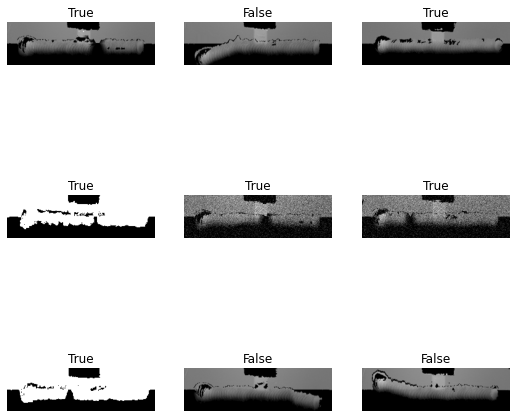

In [4]:
dls.show_batch()

In [5]:
precision = Precision()
f1 = F1Score()

In [19]:
learn = cnn_learner(dls, models.resnet34,normalize=True,pretrained=True,
                    metrics=[accuracy, precision, f1],opt_func=SGD)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=9.12010818865383e-07)

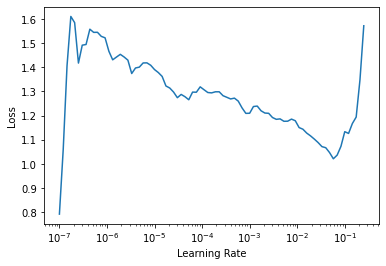

In [20]:
learn.lr_find()

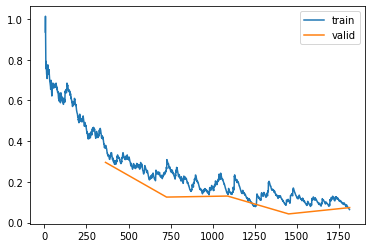

In [22]:
learn.recorder.plot_loss()

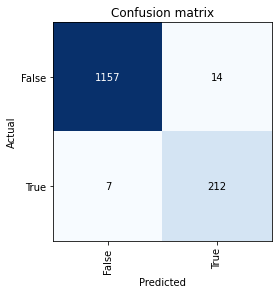

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [43]:
path = Path('/home/yani/Pruebas TFG/DatasetConIncorrectas/' +
            'Tipo2Oversampling/Completo/train/False/' +
            'Mdia_1_Pieza_1_Soldadura_42_9.png')
img = PILImage.create(path)
x, = first(dls.test_dl([img]))

In [44]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [45]:
salida_hook = Hook()
hook = learn.model[0].register_forward_hook(salida_hook.hook_func)

In [46]:
with torch.no_grad(): output = learn.model.eval()(x)

In [47]:
act = hook_output.stored[0]
salida = F.softmax(output, dim=-1)

In [48]:
dls.vocab

['False', 'True']

In [49]:
x.shape

torch.Size([1, 3, 70, 240])

In [50]:
mapaCAM = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
mapaCAM.shape

torch.Size([2, 3, 8])

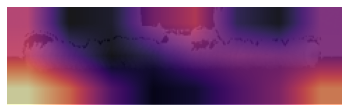

In [55]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[0].detach().cpu(), alpha=0.8, extent=(0,240,70,0),
interpolation='bilinear', cmap='magma');